In [1]:
from dataclasses import dataclass

import numpy as np
from matplotlib import pyplot as plt
from sigpyproc.viz.styles import set_seaborn

from pyloki.detection import thresholding

#### Dynamic thresholding

In [2]:
branching_pattern = np.array([4, 9, 1, 3, 1, 3, 3, 3, 1, 1, 3, 1, 1, 3, 3, 1, 1, 3, 1, 1, 1, 3,
       1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3,
       1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1])

nstages = len(branching_pattern)  # 63
ntrials = 2**10
nparams = 3  # period, accel, jerk
target_snr = 8

profile = np.zeros(64, dtype=np.float32)
profile[29:34] += np.array([4, 14, 22, 14, 4])
ducy_max = 0.3

In [3]:
dyn = thresholding.DynamicThresholdScheme(
    branching_pattern,
    profile,
    ntrials=2**10,
    nprobs=20,
    prob_min=0.05,
    snr_final=target_snr,
    nthresholds=80,
    ducy_max=ducy_max,
    wtsp=1.1,
    beam_width=0.7,
)
dyn.run(thres_neigh=10)
results_file = dyn.save(outdir=".")

Output()

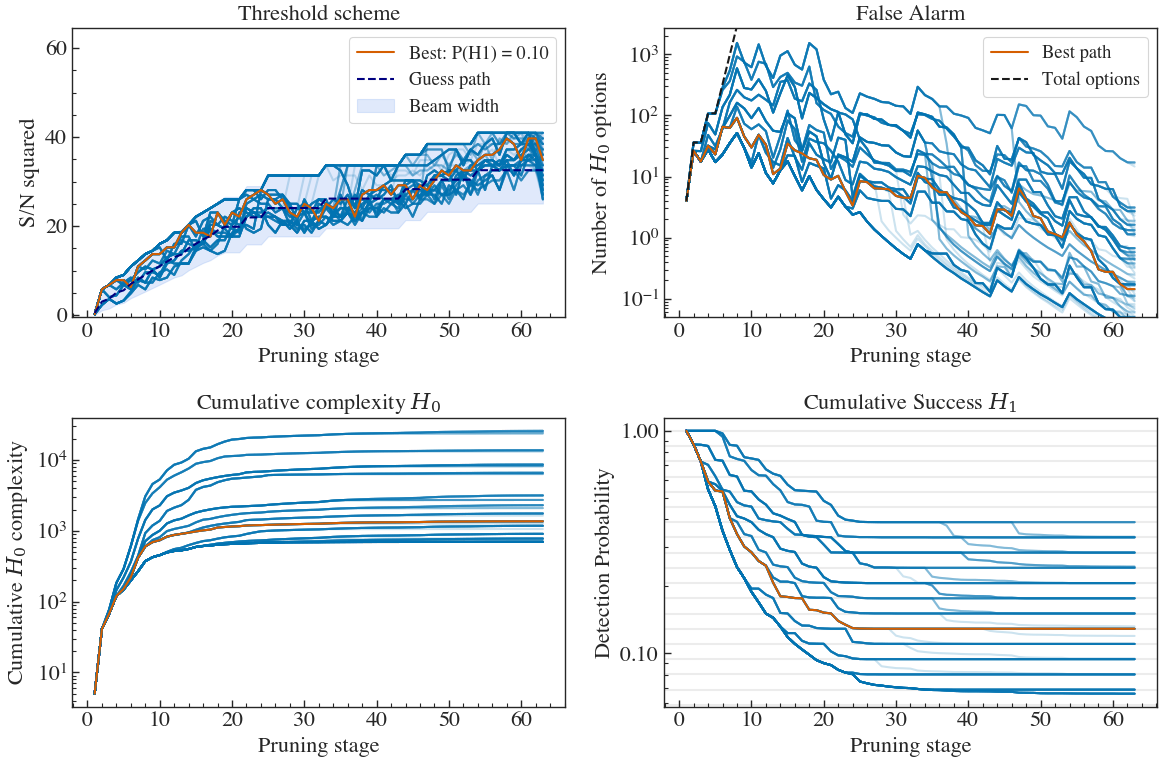

In [4]:
dyn_results = thresholding.DynamicThresholdSchemeAnalyser.from_file(results_file)
fig = dyn_results.plot_paths(best_prob=0.1, min_prob=0.05)
plt.show()

#### Dynamic thresholding comparison

In [5]:
bound_scheme = thresholding.bound_scheme(nstages, target_snr)
trials_scheme = thresholding.trials_scheme(branching_pattern, 1)
minimized_scheme = np.minimum(bound_scheme, trials_scheme)
probs = 1 / branching_pattern
probs[:10] = 1
constant_scheme = thresholding.determine_scheme(
    probs,
    branching_pattern,
    profile,
    ntrials=ntrials,
    snr_final=target_snr,
)
best_path, best_path_3, best_path_5 = dyn_results.backtrack_best(
    min_probs=[0.1, 0.2, 0.3],
)

schemes_dict = {
    "bound": bound_scheme,
    "min": minimized_scheme,
    "constant": constant_scheme.thresholds,
    "dyn_0.5": best_path_5.thresholds,
    "dyn_0.3": best_path_3.thresholds,
    "dyn_best": best_path.thresholds,
}
states_dict = {
    key: thresholding.evaluate_scheme(
        thresh_scheme,
        branching_pattern,
        profile,
        ntrials=ntrials,
        snr_final=target_snr,
    )
    for key, thresh_scheme in schemes_dict.items()
}
states_dict["dyn_best"].print_summary()

Threshold scheme summary:
Branching mean exponential growth: 1.35
Branching max exponential growth: 9.0
Total enumerated options: 27.36
Pruning complexity: 1305.51
Crude survival probability: 0.11
Total cost: 12159.98
Number of independent trials: 10.68
Total survival probability: 0.70


In [6]:
@dataclass
class SchemeLabels:
    scheme: thresholding.StatesInfo
    name: str
    color: str
    ls: str


states = [
    SchemeLabels(states_dict["bound"], "bound", "tab:orange", "-"),
    SchemeLabels(states_dict["min"], "min(bound, trials)", "navy", "--"),
    SchemeLabels(states_dict["constant"], "constant", "tab:red", "-"),
    SchemeLabels(states_dict["dyn_0.5"], "dyn_0.5", "skyblue", "-"),
    SchemeLabels(states_dict["dyn_0.3"], "dyn_0.3", "dodgerblue", "-"),
    SchemeLabels(states_dict["dyn_best"], "dyn_best", "tab:blue", "-"),
]

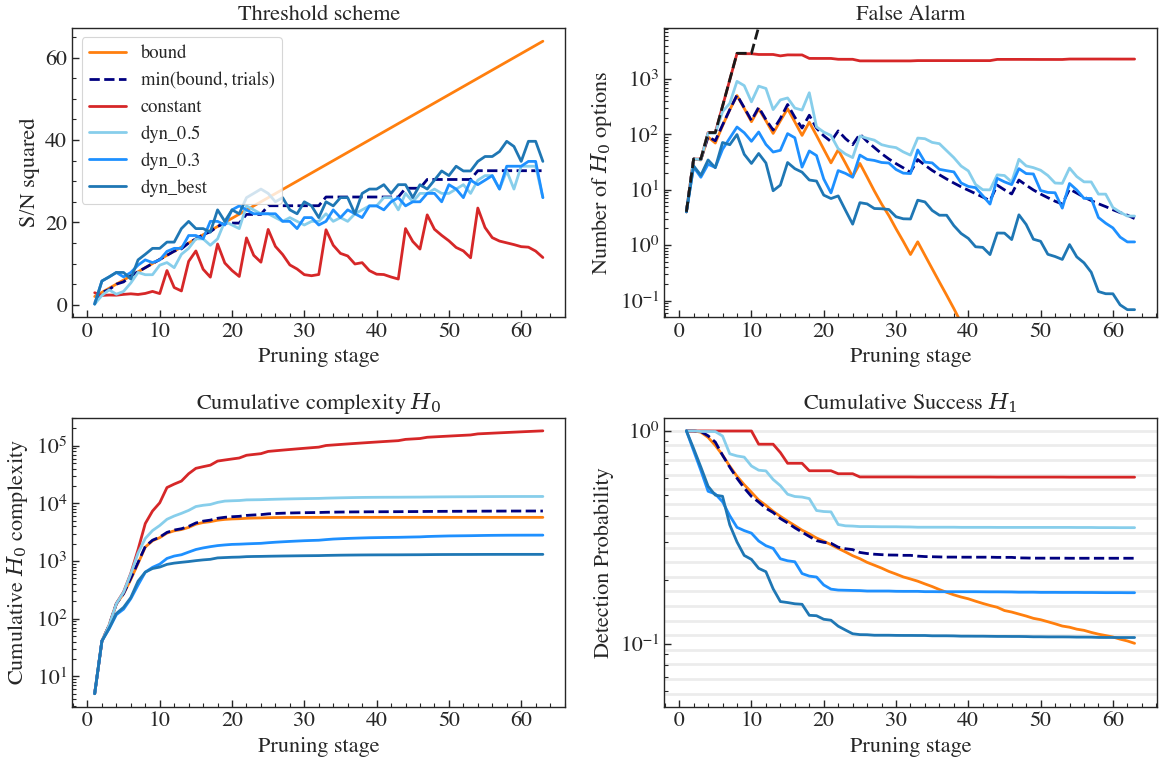

In [7]:
set_seaborn(**{"lines.linewidth": 2})
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2, 2, figsize=(12, 8))
x = np.arange(1, len(branching_pattern) + 1)

for state in states:
    ax1.plot(
        x,
        state.scheme.thresholds**2,
        label=state.name,
        c=state.color,
        ls=state.ls,
    )
    ax2.plot(
        x,
        state.scheme.get_info("complexity"),
        label=state.name,
        c=state.color,
        ls=state.ls,
    )
    ax3.plot(
        x,
        state.scheme.get_info("complexity_cumul"),
        label=state.name,
        c=state.color,
        ls=state.ls,
    )
    ax4.plot(
        x,
        state.scheme.get_info("success_h1_cumul"),
        label=state.name,
        c=state.color,
        ls=state.ls,
    )
ax1.set_xlabel("Pruning stage")
ax1.set_ylabel("S/N squared")
ax1.set_title("Threshold scheme")
ax1.legend(fontsize="small")
ax2.set_xlabel("Pruning stage")
ax2.set_ylabel(r"Number of $H_{0}$ options")
ax2.set_title("False Alarm")
ax2.set_yscale("log")
ax3.set_xlabel("Pruning stage")
ax3.set_ylabel(r"Cumulative $H_{0}$ complexity")
ax3.set_title(r"Cumulative complexity $H_{0}$")
ax3.set_yscale("log")
ax4.set_xlabel("Pruning stage")
ax4.set_ylabel("Detection Probability")
ax4.set_title(r"Cumulative Success $H_{1}$")
ax4.set_yscale("log")

ax2_current_ylim = ax2.get_ylim()
ax2.plot(x, np.cumprod(branching_pattern), color="k", ls="--", label="Total options")
ax2.set_ylim(bottom=0.05, top=ax2_current_ylim[1])
for pval in dyn_results.probs[1:]:
    ax4.axhline(y=pval, color="gray", alpha=0.15, linestyle="-", zorder=0)
plt.tight_layout()
plt.show()

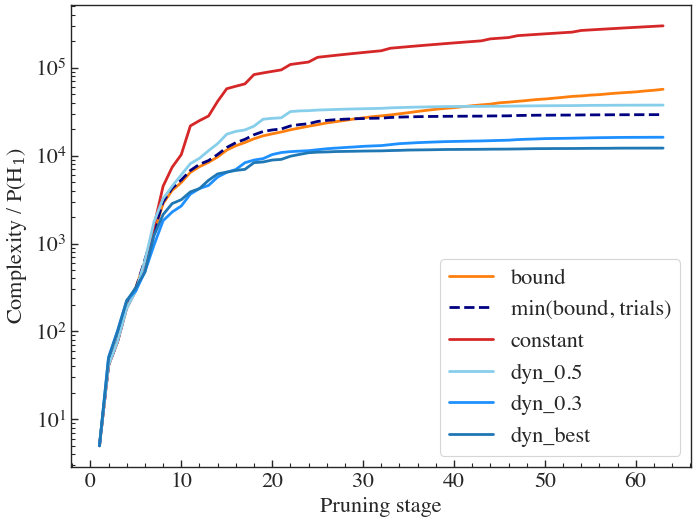

In [8]:
fig2, ax = plt.subplots(figsize=(8, 6))
for state in states:
    ax.plot(
        x,
        state.scheme.get_info("cost"),
        label=state.name,
        c=state.color,
        ls=state.ls,
    )
ax.set_xlabel("Pruning stage")
ax.set_ylabel("Complexity / P(H$_{1}$)")
ax.set_yscale("log")
ax.legend()
plt.show()

In [9]:
np.around(best_path.thresholds, decimals=1)

array([0.4, 2.4, 2.6, 2.8, 2.8, 2.5, 3.3, 3.5, 3.7, 3.7, 3.9, 3.9, 4.3,
       4.5, 4.3, 4.3, 4.2, 4.8, 4.5, 4.8, 4.7, 5.1, 5.2, 5.3, 5.2, 5. ,
       5.1, 4.8, 4.7, 5. , 4.9, 4.6, 5. , 4.9, 5.1, 5.1, 4.7, 5.2, 5.3,
       5.3, 5.4, 5.2, 5.4, 5.4, 5.1, 5.4, 5.3, 5.5, 5.7, 5.6, 5.8, 5.7,
       5.7, 5.9, 6. , 6. , 6.1, 6.3, 6.2, 5.9, 6.3, 6.3, 5.9],
      dtype=float32)